In [1]:
## loading package 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import pylab
import seaborn as sns 
from sklearn.metrics.pairwise import cosine_similarity
from statannot import add_stat_annotation
import matplotlib as mpl
from scipy import stats, cluster
import glob
import re
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats import multitest
from matplotlib.gridspec import GridSpec

from matplotlib_venn import venn2, venn3
from matplotlib import pyplot as plt

import warnings 
warnings.simplefilter('ignore')

## load_large_dataFrame
def load_large_dataFrame(input_file, sep=",", header=0, index_col=0, chunksize=100000, compressed=False):
    if compressed:
        TextFileReader = pd.read_csv(input_file, chunksize=chunksize, sep=sep, header=header,index_col=index_col, compression='gzip')
    else:
        TextFileReader = pd.read_csv(input_file, chunksize=chunksize, sep=sep, header=header,index_col=index_col)
    dfList=[]
    for df in TextFileReader:
        dfList.append(df)
    final_df = pd.concat(dfList,sort=False)
    return final_df

In [2]:
#from multiprocesspandas import applyparallel
from joblib import Parallel, delayed
import time
from pandarallel import pandarallel

## 1. load data
    1.1) RBP peaks and motifs (10nt)
    1.2) load reac matrix (10nt)
    1.3) load Rsq matrix (10nt)
    1.4) 

### 1.1 loading RBP targets (10nt)

In [69]:
## the RBP binding wins in Eclip
rbp_binding_wins = load_large_dataFrame("../Current_Data/07.RBP_targets/clip.allPeak.ENCODE_genome2TransCoords.longestCDS.binding_wins.csv", 
                                        header=[0], index_col=[0,1])
rbp_binding_wins

## PUM2 binding Motifs
rbp_binding_motifs = load_large_dataFrame("../Current_Data/07.RBP_targets/fimo.RBP_motifs_on_ref.rbp.txt", header=[0], index_col=[0,1])
#rbp_binding_motifs

In [70]:
rbp_binding_wins = load_large_dataFrame("../Current_Data/07.RBP_targets/clip.allPeak.ENCODE_genome2TransCoords.longestCDS.binding_wins.with_annot.csv", 
                                        header=[0], index_col=[0,1])
#rbp_binding_wins

### 1.2. load reac matrix (10nt)

In [71]:
wide_reac_df_10nt = load_large_dataFrame("../Current_Data/03.Wide_Reac_Matrix_10nt/neural_differentiate.stages.transcripts.crude_reac.10nt.csv", header=[0,1,2,3], index_col=[0,1])
#wide_reac_df_10nt

### 1.3. load Rsq matrix (10nt)

In [72]:
long_rsq_df_10nt = load_large_dataFrame("../Data/04.heterogeneity_dataframe/rsq.Mut_vs_Cov.genome.10nt.stage.csv",  header=[0], index_col=[0,1])
long_rsq_df_10nt['rsq'] = np.power(long_rsq_df_10nt['r'],2)
wide_rsq_df_10nt = long_rsq_df_10nt.reset_index().pivot(index=['gene','pos'], columns=['stage'], values='rsq')
#wide_rsq_df_10nt

### 1.4. load gene expression of each cell

In [73]:
#gene_expr = load_large_dataFrame("../../../scSHAPE-Map_April-2021/Gene_Expr/gene_expr.TPM.txt", header=[0,1,2,3,4], index_col=[0])
gene_expr = load_large_dataFrame("../../Gene_Expr/gene_expr.TPM.txt", header=[0,1,2,3,4], index_col=[0])

#avg_gene_expr = gene_expr.groupby(level="stage", axis=1).mean()
#avg_gene_expr
#gene_expr

## 2. Most Single/Double and Homo/Hetero wins

### 2.1 Most Single/Double wins (h9)

In [74]:
wide_avg_reac_df_10nt = wide_reac_df_10nt.groupby(level="stage", axis=1).mean()
wide_h9_reac_df_10nt = wide_avg_reac_df_10nt[['h9']].dropna()
wide_h9_reac_df_10nt = wide_h9_reac_df_10nt.loc[wide_h9_reac_df_10nt.index.get_level_values('gene')!="human_small"]
wide_h9_reac_df_10nt['reac.qtl'] = pd.qcut(wide_h9_reac_df_10nt['h9'], [0, .25, .5, .75, 1.], labels=[1,2,3,4])
wide_h9_reac_df_10nt.columns = ['reac', 'reac.qtl']

### 2.2 Most Homo/Hetero wins (h9)

In [75]:
wide_rsq_df_10nt
wide_h9_rsq_df_10nt = wide_rsq_df_10nt[['h9']].dropna()
wide_h9_rsq_df_10nt = wide_h9_rsq_df_10nt.loc[wide_h9_rsq_df_10nt.index.get_level_values('gene')!="human_small"]
wide_h9_rsq_df_10nt['rsq.qtl'] = pd.qcut(wide_h9_rsq_df_10nt['h9'], [0, .25, .5, .75, 1.], labels=[1,2,3,4])
wide_h9_rsq_df_10nt.columns = ['rsq', 'rsq.qtl']

In [76]:
wide_h9_reac2rsq = pd.concat([wide_h9_reac_df_10nt, wide_h9_rsq_df_10nt], axis=1, join="inner")
wide_h9_reac2rsq

reac reac.qtl       rsq rsq.qtl
gene  pos                                      
AARS1 3160  0.000760        1  0.056084       2
      3170  0.009422        3  0.350402       3
      3180  0.006138        3  0.514118       4
      3190  0.009888        4  0.718837       4
      3200 -0.008212        1  0.322359       3
...              ...      ...       ...     ...
ZYX   2080 -0.003270        1  0.680677       4
      2090  0.000433        1  0.060489       2
      2100 -0.002050        1  0.275267       3
      2110  0.017561        4  0.172739       2
      2120  0.006327        3  0.000124       1

[55254 rows x 4 columns]

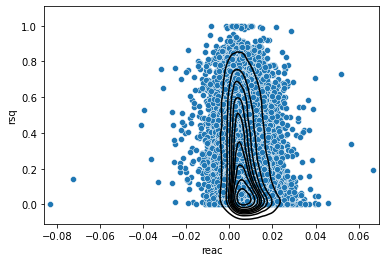

In [25]:
sns.scatterplot(data=wide_h9_reac2rsq, x="reac", y="rsq")
sns.kdeplot(data=wide_h9_reac2rsq, x="reac", y="rsq", color="black")
plt.show()

In [26]:
stats.linregress(wide_h9_reac2rsq['rsq'], wide_h9_reac2rsq['reac'])

LinregressResult(slope=-0.005191722053706817, intercept=0.007827967745870398, rvalue=-0.21977782593522824, pvalue=0.0, stderr=9.787534260992797e-05, intercept_stderr=3.232895067641194e-05)

## 3. Enrichment of RBP at single/double, homo/hetero wins

In [193]:
def RBP_enrichment_at_certain_subset(rbp_peaks, detected_wins, subset_wins):
    
    rbp_peaks_in_allset = rbp_peaks.loc[rbp_peaks.index.get_level_values('target').isin(detected_wins.index.get_level_values('gene'))]
    
    
    rbp_peaks_in_subset = rbp_peaks.loc[rbp_peaks.index.isin(subset_wins.index)]
    rbp_peaks_not_in_subset =  rbp_peaks_in_allset.loc[~rbp_peaks_in_allset.index.isin(subset_wins.index)]
    
    #print (rbp_peaks_in_allset.index.size, subset_wins.index.size)
    subset_wins_with_rbp = subset_wins.loc[subset_wins.index.isin(rbp_peaks_in_allset.index)]
    subset_wins_without_rbp = subset_wins.loc[~subset_wins.index.isin(rbp_peaks_in_allset.index)]
    
    
    allother = detected_wins.loc[~((detected_wins.index.isin(rbp_peaks.index))|(detected_wins.index.isin(subset_wins.index)))]
    #print ([[subset_wins_with_rbp.index.size, subset_wins_without_rbp.index.size],[rbp_peaks_not_in_subset.index.unique().size, allother.index.unique().size]])
    a = subset_wins_with_rbp.index.unique().size
    b = subset_wins_without_rbp.index.unique().size 
    c = rbp_peaks_not_in_subset.index.unique().size
    d = allother.index.unique().size
    s, p = stats.fisher_exact([[a,b],[c,d]],alternative="greater" )
    try:
        fc = (a/b)/(c/d)
    except:
        fc = np.nan
    print (a, b, c, d, detected_wins.index.unique().size, p, fc)

In [197]:
for rbp in rbp_binding_wins['rbp'].unique():
    one_rbp_binding_wins = rbp_binding_wins.loc[rbp_binding_wins['rbp']==rbp]
    #print (rbp)
    if rbp not in ['DDX3X','PUM2','LIN28B']:
        continue
        
    for group_id, subset in wide_h9_reac2rsq.groupby('reac.qtl'):
        print (group_id)
        RBP_enrichment_at_certain_subset(one_rbp_binding_wins, wide_h9_reac2rsq, subset)
    
    for group_id, subset in wide_h9_reac2rsq.groupby('rsq.qtl'):
        print (group_id)
        RBP_enrichment_at_certain_subset(one_rbp_binding_wins, wide_h9_reac2rsq, subset)
    

1
761 12996 8045 38808 55254 1.0 0.28246859338657726
2
862 12995 7944 38809 55254 1.0 0.324059083069753
3
895 12946 7911 38858 55254 1.0 0.3395756119909851
4
932 12867 7874 38937 55254 1.0 0.35818359256210236
1
882 12889 7924 38915 55254 1.0 0.3360639513190501
2
908 12905 7898 38899 55254 1.0 0.3465366295117455
3
829 13015 7977 38789 55254 1.0 0.30972720216415506
4
831 12995 7975 38809 55254 1.0 0.31119062190545915
1
1086 12671 12339 38614 55254 1.0 0.26821543238413403
2
1060 12797 12365 38488 55254 1.0 0.25782731060507796
3
1030 12811 12395 38474 55254 1.0 0.2495600149994636
4
793 13006 12632 38279 55254 1.0 0.18476423338300432
1
827 12944 12598 38341 55254 1.0 0.1944459209881059
2
976 12837 12449 38448 55254 1.0 0.23481485226257365
3
1104 12740 12321 38545 55254 1.0 0.27109514368201626
4
1062 12764 12363 38521 55254 1.0 0.2592456063678854
1
253 13504 3542 40433 55254 1.0 0.21386784867975628
2
293 13564 3502 40373 55254 1.0 0.24903174930919533
3
303 13538 3492 40399 55254 1.0 0.258931

In [195]:
wide_h9_reac2rsq

reac reac.qtl       rsq rsq.qtl
gene  pos                                      
AARS1 3160  0.000760        1  0.056084       2
      3170  0.009422        3  0.350402       3
      3180  0.006138        3  0.514118       4
      3190  0.009888        4  0.718837       4
      3200 -0.008212        1  0.322359       3
...              ...      ...       ...     ...
ZYX   2080 -0.003270        1  0.680677       4
      2090  0.000433        1  0.060489       2
      2100 -0.002050        1  0.275267       3
      2110  0.017561        4  0.172739       2
      2120  0.006327        3  0.000124       1

[55254 rows x 4 columns]

## 4. structure/heterogeneity changes with rbp expression

In [12]:
h9_gene_expr = gene_expr.xs('h9', level="stage", axis=1, drop_level=False)
h9_gene_expr = h9_gene_expr.xs('nai-n3', level="agent", axis=1)
h9_gene_expr

batch               batch_1                                               \
stage                    h9                                                
lib_type             single                                                
id                  RHE1585        RHE1613        RHE1576        RHE1586   
transcript                                                                 
OR4F5              0.000000       0.000000       0.000000       0.000000   
OR4F29             0.000000       0.000000       0.000000       0.000000   
OR4F16             0.000000       0.000000       0.000000       0.000000   
SAMD11             0.000000       0.000000       0.000000       0.000000   
NOC2L              0.000000       0.000000      29.744975      19.098270   
...                     ...            ...            ...            ...   
LINC00266-4P       0.000000       0.000000       0.000000       0.000000   
CSPG4P1Y           0.000000       0.000000       0.000000       0.000000   
TTTY3              0.000000       0.000000       0.000000       0.000000   
human_small   264125.593761  256451.984521  313845.092826  285887.563320   
human_large    18704.275077   17453.905912   23453.330008   26575.772524   

batch                                                                     \
stage                                                                      
lib_type                                                                   
id                  RHE1614        RHE1587        RHE1615        RHE1588   
transcript                                                                 
OR4F5              0.000000       0.000000       0.000000       0.000000   
OR4F29             0.000000       0.000000       0.000000       0.000000   
OR4F16             0.000000       0.000000       0.000000       0.000000   
SAMD11             0.000000       0.000000       0.000000       0.000000   
NOC2L             22.811232       0.000000       0.000000      36.873040   
...                     ...            ...            ...            ...   
LINC00266-4P       0.000000       0.000000       0.000000       0.000000   
CSPG4P1Y           0.000000       0.000000       0.000000       0.000000   
TTTY3              0.000000       0.000000       0.000000       0.000000   
human_small   277721.977687  273066.509756  265839.713795  287235.846081   
human_large    25771.535463   17215.433631   16785.056415   19836.838440   

batch                                       ...        batch_2                 \
stage                                       ...             h9                  
lib_type                                    ...         single                  
id                  RHE1589        RHE1590  ...        RHS3587        RHS3588   
transcript                                  ...                                 
OR4F5              0.000000       0.000000  ...       0.000000       0.000000   
OR4F29             0.000000       0.000000  ...       0.000000       0.000000   
OR4F16             0.000000       0.000000  ...       0.000000       0.000000   
SAMD11             0.000000       0.000000  ...       0.000000       0.000000   
NOC2L              0.000000      37.049052  ...      15.935267       0.000000   
...                     ...            ...  ...            ...            ...   
LINC00266-4P       0.000000       0.000000  ...       1.439382       0.000000   
CSPG4P1Y           0.000000       0.000000  ...       0.000000       0.000000   
TTTY3              0.000000       0.000000  ...       0.000000       0.000000   
human_small   292379.482221  273861.251288  ...  314678.464345  294166.797559   
human_large    19342.249572   22722.174491  ...   17747.948464   14037.653571   

batch                                                                     \
stage                                                                      
lib_type                                                                   
id                  RHS3589        RHS359

In [13]:
h9_reac = wide_reac_df_10nt.xs('h9', level="stage", axis=1, drop_level=False)
#h9_reac = h9_reac.xs('nai-n3', level="agent", axis=1, drop_level=False)
h9_reac

id            RHE1552   RHE1558   RHE1564   RHE1570 RHE1576 RHE1577 RHE1578  \
batch         batch_1   batch_1   batch_1   batch_1 batch_1 batch_1 batch_1   
stage              h9        h9        h9        h9      h9      h9      h9   
lib_type       single    single    single    single  single  single  single   
gene   pos                                                                    
AARS1  3160 -0.002726 -0.001642 -0.001371 -0.002812     NaN     NaN     NaN   
       3170 -0.007441  0.015069 -0.007218 -0.006944     NaN     NaN     NaN   
       3180  0.002416 -0.006812  0.022024 -0.003761     NaN     NaN     NaN   
       3190  0.011067 -0.006659 -0.003884 -0.002244     NaN     NaN     NaN   
       3200 -0.000968 -0.004852 -0.005662 -0.002084     NaN     NaN     NaN   
...               ...       ...       ...       ...     ...     ...     ...   
VIM    2070       NaN       NaN       NaN       NaN     NaN     NaN     NaN   
TUBA1A 970        NaN       NaN       NaN       NaN     NaN     NaN     NaN   
       980        NaN       NaN       NaN       NaN     NaN     NaN     NaN   
       990        NaN       NaN       NaN       NaN     NaN     NaN     NaN   
       1000       NaN       NaN       NaN       NaN     NaN     NaN     NaN   

id            RHE1579   RHE1580 RHE1581  ...   RHS3587 RHS3588 RHS3589  \
batch         batch_1   batch_1 batch_1  ...   batch_2 batch_2 batch_2   
stage              h9        h9      h9  ...        h9      h9      h9   
lib_type       single    single  single  ...    single  single  single   
gene   pos                               ...                             
AARS1  3160       NaN  0.003224     NaN  ... -0.000563     NaN     NaN   
       3170       NaN -0.000724     NaN  ...  0.112065     NaN     NaN   
       3180       NaN  0.030547     NaN  ...  0.007765     NaN     NaN   
       3190       NaN -0.002643     NaN  ...  0.104065     NaN     NaN   
       3200 -0.000937  0.091476     NaN  ... -0.032407     NaN     NaN   
...               ...       ...     ...  ...       ...     ...     ...   
VIM    2070       NaN       NaN     NaN  ...       NaN     NaN     NaN   
TUBA1A 970        NaN       NaN     NaN  ...       NaN     NaN     NaN   
       980        NaN       NaN     NaN  ...       NaN     NaN     NaN   
       990        NaN       NaN     NaN  ...       NaN     NaN     NaN   
       1000       NaN       NaN     NaN  ...       NaN     NaN     NaN   

id            RHS3590   RHS3591 RHS3592 RHS3593 RHS3594   RHS3595   RHS3596  
batch         batch_2   batch_2 batch_2 batch_2 batch_2   batch_2   batch_2  
stage              h9        h9      h9      h9      h9        h9        h9  
lib_type       single    single  single  single  single    single    single  
gene   pos                                                                   
AARS1  3160  0.000395 -0.004404     NaN     NaN     NaN -0.002517 -0.010357  
       3170  0.020188  0.030179     NaN     NaN     NaN  0.012907  0.008371  
       3180  0.007952  0.003784     NaN     NaN     NaN  0.008174 -0.001048  
       3190  0.001683  0.000664     NaN     NaN     NaN  0.007508  0.016626  
       3200 -0.035580 -0.036533     NaN     NaN     NaN  0.072747 -0.038300  
...               ...       ...     ...     ...     ...       ...       ...  
VIM    2070       NaN       NaN     NaN     NaN     NaN       NaN       NaN  
TUBA1A 970        NaN       NaN     NaN     NaN     NaN       NaN       NaN  
       980        NaN       NaN     NaN     NaN     NaN       NaN       NaN  
       990        NaN       NaN     NaN     NaN     NaN       NaN       NaN  
       1000       NaN       NaN     NaN     NaN     NaN       NaN       NaN  

[56080 rows x 76 columns]

In [77]:

n = 0

def ttest_for_each_row(row):
    if 0 in row.index.get_level_values('qtl.rbp_expr'):
        g1 = row.xs(0, level='qtl.rbp_expr')
    else:
        g1 = row.xs(1, level='qtl.rbp_expr')
    g2 = row.xs(4, level='qtl.rbp_expr')        
    s, p = stats.ttest_ind(g1.dropna(), g2.dropna())
    foldchange = g2.mean()/g1.mean()
    return p, foldchange


concat_lst = []
for rbp in rbp_binding_wins['rbp'].unique():
    if rbp not in h9_gene_expr.index:
        continue
    rbp_expr = h9_gene_expr.loc[[rbp]].T
    
    if (rbp_expr[rbp]==0).sum() <= 0.25*rbp_expr.index.size:
        rbp_expr['qtl.rbp_expr'] = pd.qcut( rbp_expr[rbp], [0, .25, .5, .75, 1.], labels=[1,2,3,4])
    else:
        rbp_zero_expr = rbp_expr.loc[rbp_expr[rbp]==0]
        rbp_other_expr = rbp_expr.loc[rbp_expr[rbp]!=0]
        rbp_zero_expr['qtl.rbp_expr'] = 0
        rbp_other_expr['qtl.rbp_expr'] = pd.qcut( rbp_other_expr[rbp], [0, .33, .66, 1.], labels=[2,3,4])
        rbp_expr = pd.concat([rbp_zero_expr, rbp_other_expr])
    rbp_expr = rbp_expr.sort_values(rbp)
    rbp_expr = rbp_expr.reset_index()
    rbp_expr = rbp_expr.set_index(['id','batch','stage','lib_type'])
    
    local_wide_reac_df_10nt = wide_reac_df_10nt.xs('h9', level="stage", drop_level=False, axis=1)
    local_wide_reac_df_10nt = local_wide_reac_df_10nt.loc[:, rbp_expr.index]
    local_wide_reac_df_10nt.columns = pd.MultiIndex.from_frame(rbp_expr.reset_index())
    
    
    single_rbp_binding_wins = rbp_binding_wins.loc[rbp_binding_wins['rbp']==rbp]
    rbp_target_reac_df = local_wide_reac_df_10nt.loc[local_wide_reac_df_10nt.index.isin(single_rbp_binding_wins.index)]
    rbp_target_reac_test = rbp_target_reac_df.apply(ttest_for_each_row, axis=1, result_type="expand")
    if rbp_target_reac_test.index.size == 0 :
        continue
    rbp_target_reac_test.columns = ['pval', 'fc']
    rbp_target_reac_test = rbp_target_reac_test.dropna()

    rbp_target_reac_test['rbp'] = rbp
    concat_lst.append(rbp_target_reac_test)

rbp_target_reac_test = pd.concat(concat_lst)

_, adj_pval, _, _ = multitest.multipletests(rbp_target_reac_test['pval'], alpha=0.05, method="fdr_bh")
rbp_target_reac_test['adj_pval'] = adj_pval
rbp_target_reac_test['log2fc'] = np.log2(rbp_target_reac_test['fc'])
rbp_target_reac_test['log10adj_pval'] = -1*np.log10(rbp_target_reac_test['adj_pval'])
rbp_target_reac_test['log10pval'] = -1*np.log10(rbp_target_reac_test['pval'])

rbp_target_reac_test

pval        fc     rbp  adj_pval    log2fc  log10adj_pval  \
gene       pos                                                                  
AC253536.7 680  0.659567  0.601628  GTF2F1  0.920852 -0.733057       0.035810   
           690  0.325299  0.328658  GTF2F1  0.860590 -1.605341       0.065204   
           700  0.703923  0.739789  GTF2F1  0.932874 -0.434814       0.030177   
           710  0.968077  1.680054  GTF2F1  0.994288  0.748507       0.002488   
           720  0.309552  2.790648  GTF2F1  0.859868  1.480600       0.065568   
...                  ...       ...     ...       ...       ...            ...   
XRCC5      860  0.023832  0.118239    PPIG  0.859678 -3.080223       0.065664   
           870  0.961927  0.943511    PPIG  0.992923 -0.083888       0.003084   
           880  0.844427  0.760448    PPIG  0.967744 -0.395078       0.014240   
           890  0.019434 -0.103781    PPIG  0.859678       NaN       0.065664   
ZRANB2     230  0.432388  0.520483    PPIG  0.872301 -0.942078       0.059334   

                log10pval  
gene       pos             
AC253536.7 680   0.180741  
           690   0.487717  
           700   0.152475  
           710   0.014090  
           720   0.509266  
...                   ...  
XRCC5      860   1.622847  
           870   0.016858  
           880   0.073438  
           890   1.711444  
ZRANB2     230   0.364126  

[119959 rows x 7 columns]

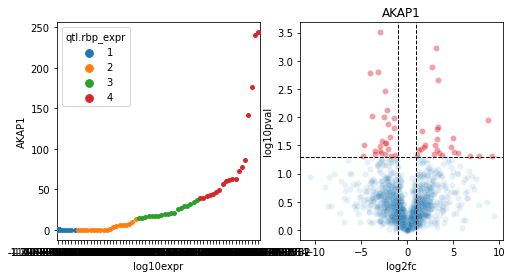

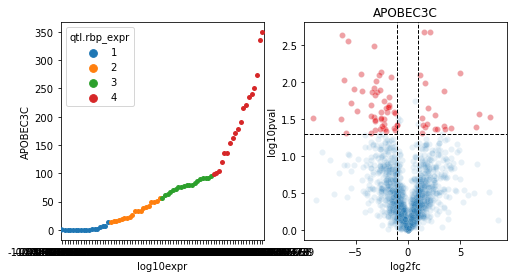

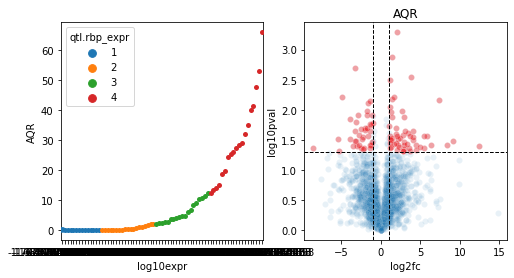

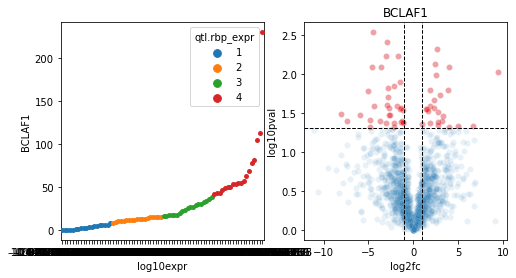

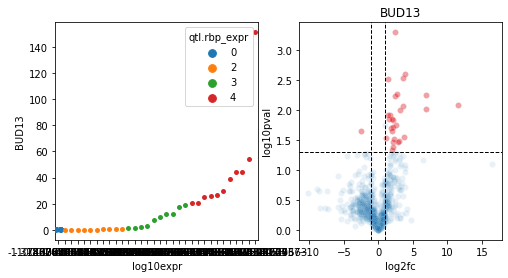

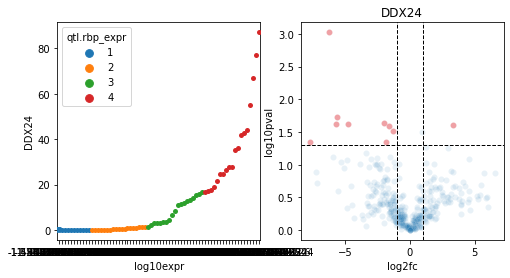

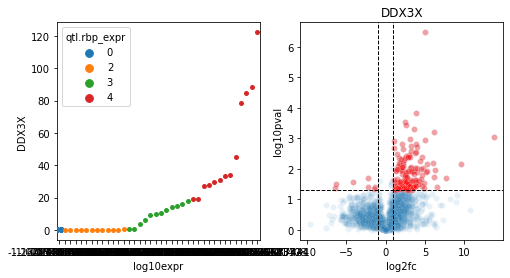

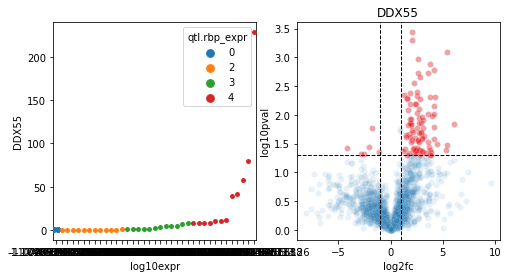

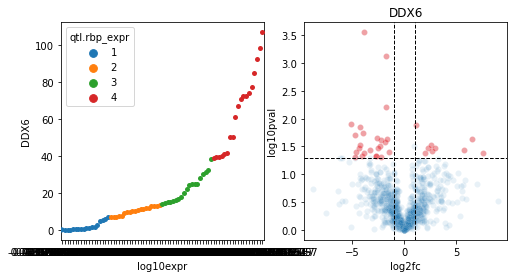

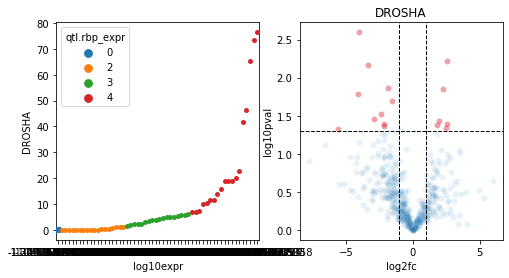

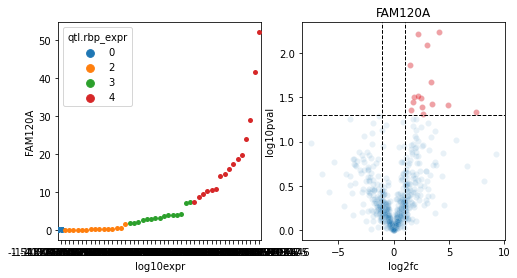

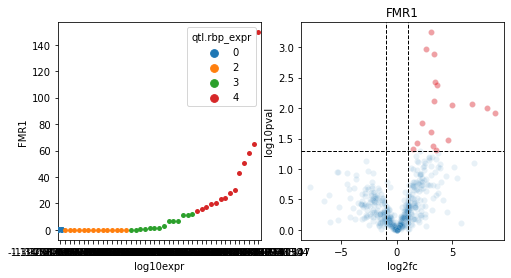

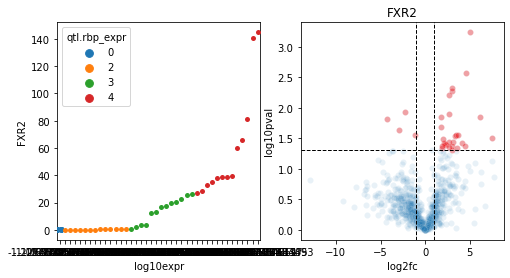

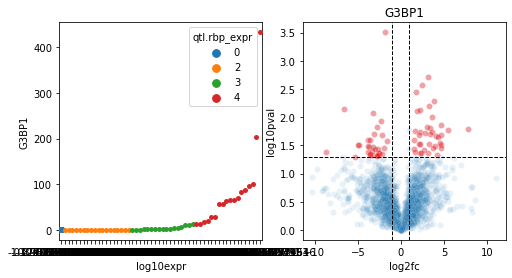

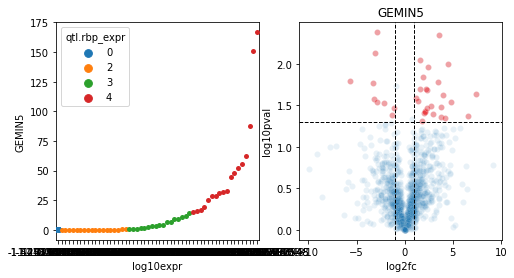

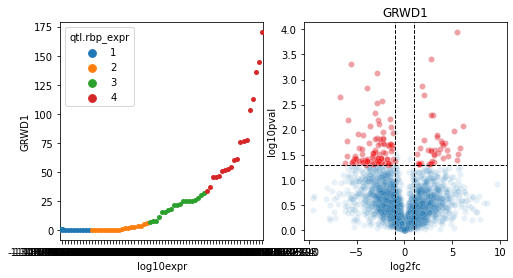

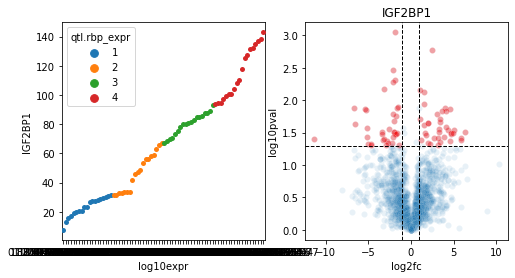

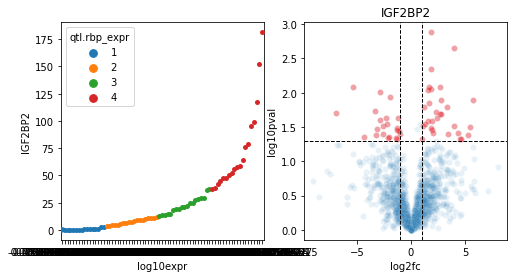

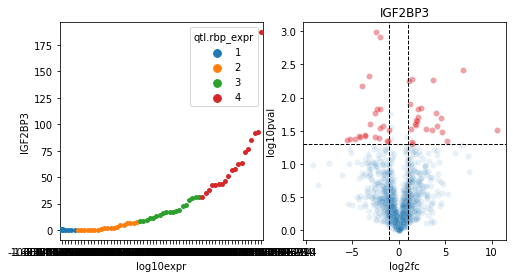

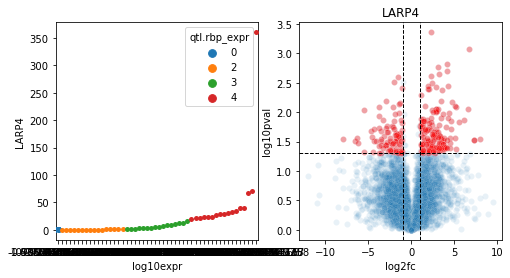

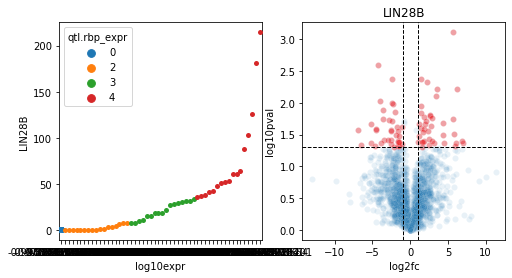

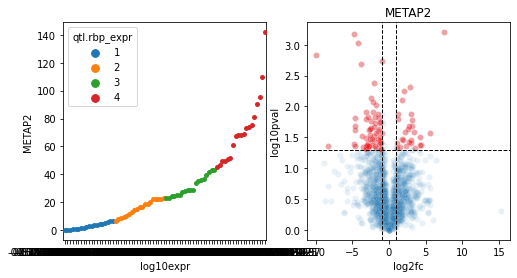

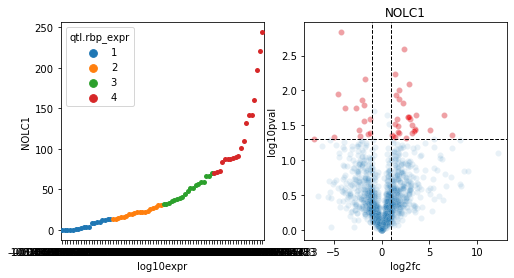

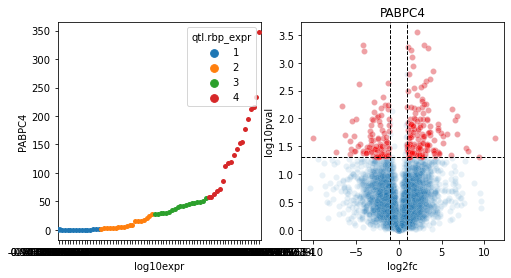

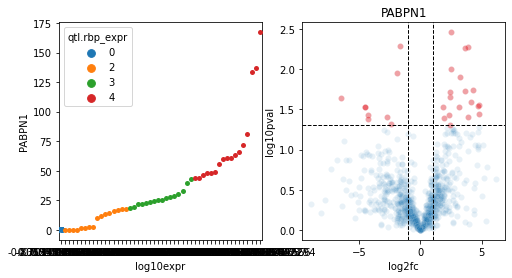

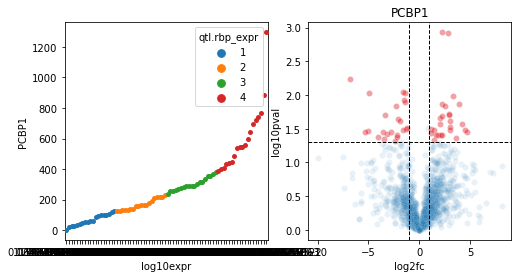

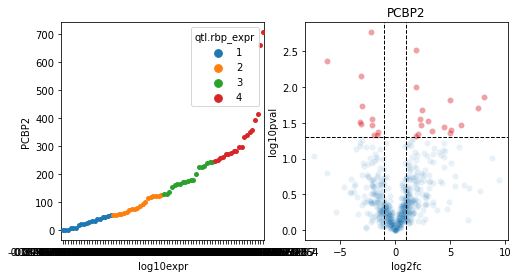

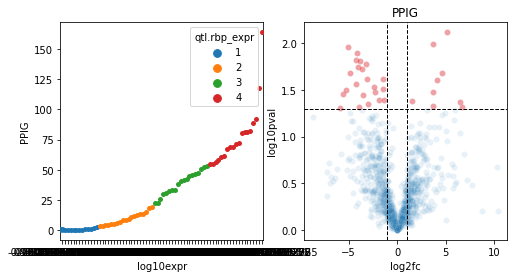

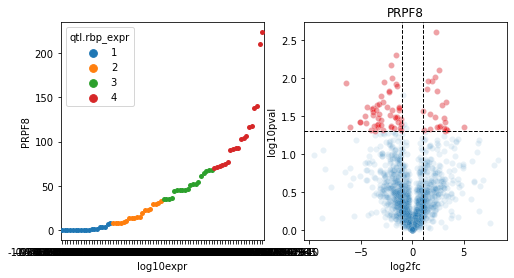

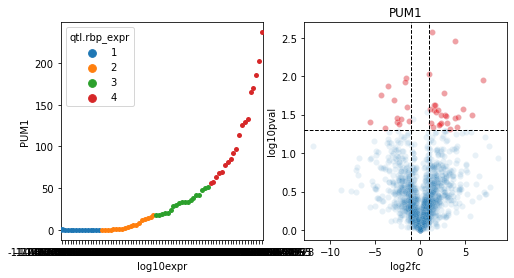

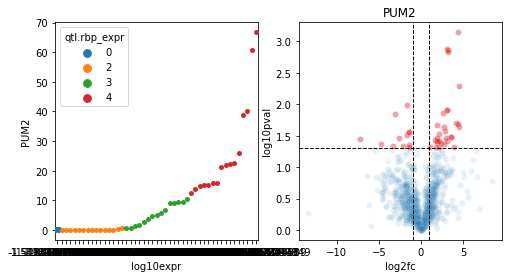

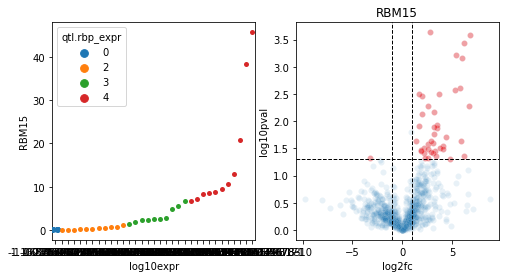

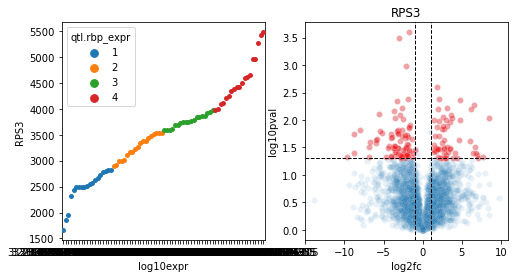

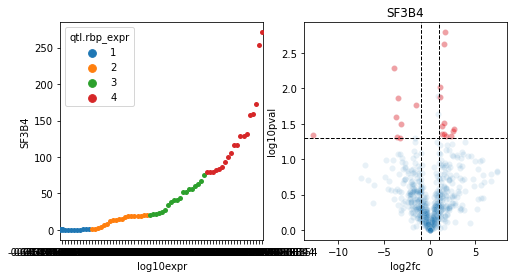

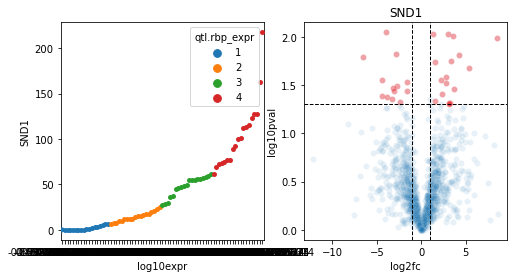

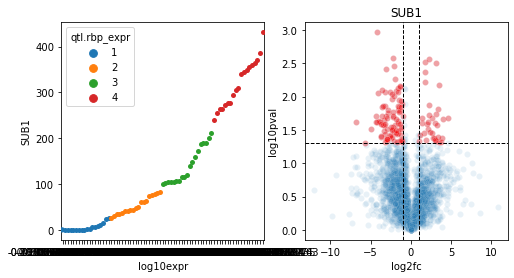

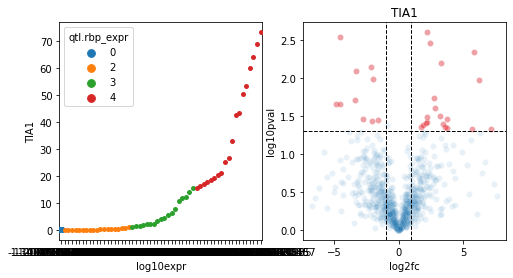

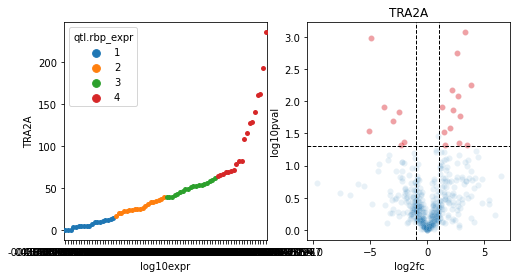

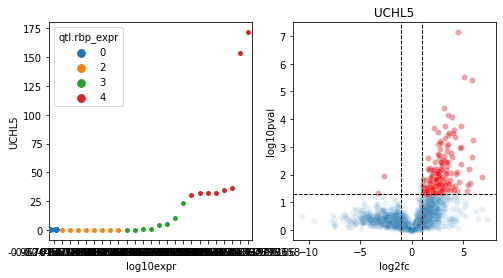

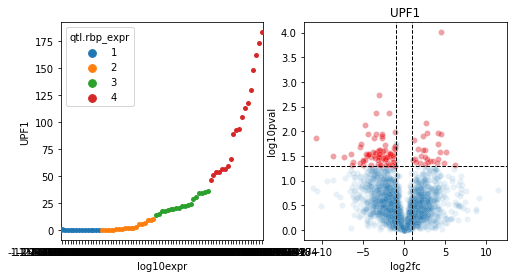

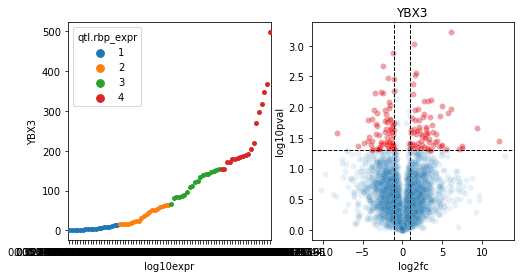

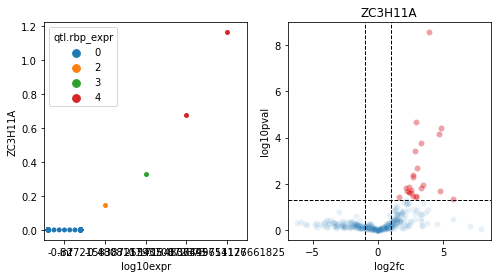

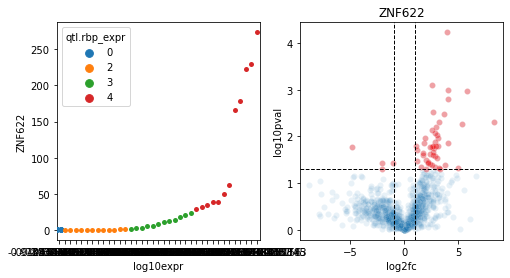

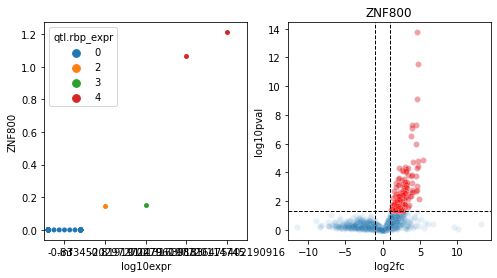

In [78]:
#rbp_target_reac_test = load_large_dataFrame("../Current_Data/07.RBP_targets/reac_diff_at_rbp_targets_ranking_by_rbp_expr.csv", index_col=[0,1])

n = 0
for rbp, subset in rbp_target_reac_test.groupby('rbp'):
    
    if subset.index.size < 500:
        continue
        
    fig, axs = plt.subplots(1,2, figsize=(8,4))
    ax = axs[1]
    #sns.scatterplot(data=subset, x="log2fc", y="log10adj_pval", ax=ax)
    sns.scatterplot(data=subset, x="log2fc", y="log10pval", ax=ax, alpha=0.1)
    sig_subset = subset.loc[(np.abs(subset['log2fc'])>=1)&(subset['pval']<0.05)]
    sns.scatterplot(data=sig_subset, x="log2fc", y="log10pval", ax=ax, color="red", alpha=0.33)   
    ax.axvline(x=1, ls="--", lw=1, color="black")
    ax.axvline(x=-1, ls="--", lw=1, color="black")
    ax.axhline(y=-1*np.log10(0.05), ls="--", lw=1, color="black")
    ax.set_title(rbp)
    
    ## RBP expression
    if rbp not in h9_gene_expr.index:
        continue
    rbp_expr = h9_gene_expr.loc[[rbp]].T
    
    if (rbp_expr[rbp]==0).sum() <= 0.25*rbp_expr.index.size:
        rbp_expr['qtl.rbp_expr'] = pd.qcut( rbp_expr[rbp], [0, .25, .5, .75, 1.], labels=[1,2,3,4])
    else:
        rbp_zero_expr = rbp_expr.loc[rbp_expr[rbp]==0]
        rbp_other_expr = rbp_expr.loc[rbp_expr[rbp]!=0]
        rbp_zero_expr['qtl.rbp_expr'] = 0
        rbp_other_expr['qtl.rbp_expr'] = pd.qcut( rbp_other_expr[rbp], [0, .33, .66, 1.], labels=[2,3,4])
        rbp_expr = pd.concat([rbp_zero_expr, rbp_other_expr])
    rbp_expr = rbp_expr.sort_values(rbp)
    rbp_expr = rbp_expr.reset_index()
    rbp_expr = rbp_expr.set_index(['id','batch','stage','lib_type'])
    rbp_expr['log10expr'] = np.log10(rbp_expr[rbp])
    # print (rbp_expr)
    ax = axs[0]
    PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
     }
    sns.swarmplot(data=rbp_expr, x="log10expr", y=rbp, hue="qtl.rbp_expr", ax=ax)
    #sns.boxplot(data=rbp_expr, x="log10expr", y=rbp, hue="qtl.rbp_expr", ax=ax, **PROPS)
    
    
    plt.show()
    
    n += 1
    # if n >= 10:
    #break

In [143]:
rbp_target_reac_test.to_csv("../Current_Data/07.RBP_targets/reac_diff_at_rbp_targets_ranking_by_rbp_expr.csv")

## 5. plot RBP enrichment heatmap

In [47]:
rbp_enrich_at_rsq = load_large_dataFrame("../Current_Data/07.RBP_targets/rbp_enrich_heterogeneity.all.from_zt.csv", index_col=None)
rbp_enrich_at_rsq
rbp_enrich_at_reac = load_large_dataFrame("../Current_Data/07.RBP_targets/zhangyu_rbp_enrichment.from_zt.txt", index_col=None, sep="\t")
rbp_enrich_at_reac

,batch,stage,qtl,rbp,pval_hypergeom,pval_fisher,num_winset_with_rbp,num_other_with_rbp,num_winset_without_rbp,num_other_without_rbp
0,merge,day0,0.25,AATF,2.616886e-01,6.836842e-01,1.0,3.0,1749.0,5247.0
1,merge,day0,0.25,AGGF1,5.722181e-01,6.763786e-01,17.0,56.0,1733.0,5194.0
2,merge,day0,0.25,AKAP1,8.814482e-02,1.095981e-01,98.0,253.0,1652.0,4997.0
3,merge,day0,0.25,AKAP8L,NaN,NaN,NaN,NaN,NaN,NaN
4,merge,day0,0.25,APOBEC3C,9.980811e-01,9.987250e-01,76.0,325.0,1674.0,4925.0
...,...,...,...,...,...,...,...,...,...,...
2187,merge,h9,1.00,ZC3H11A,3.302170e-04,4.279990e-04,293.0,694.0,14750.0,44435.0
2188,merge,h9,1.00,ZC3H8,1.544877e-02,4.005075e-02,11.0,15.0,15032.0,45114.0
2189,merge,h9,1.00,ZNF622,5.310000e-16,7.900000e-16,679.0,1399.0,14364.0,43730.0
2190,merge,h9,1.00,ZNF800,2.622671e-03,2.943385e-03,1056.0,2875.0,13987.0,42254.0


In [48]:
h9_rbp_enrich_at_rsq = rbp_enrich_at_rsq.loc[rbp_enrich_at_rsq['stage']=="h9"]
h9_rbp_enrich_at_reac = rbp_enrich_at_reac.loc[rbp_enrich_at_reac['stage']=="h9"]

_, adj_pval, _, _ = multitest.multipletests(h9_rbp_enrich_at_reac['pval_fisher'])
h9_rbp_enrich_at_reac['adj_pval'] = adj_pval
h9_rbp_enrich_at_reac['log10adj_pval'] = np.log10(h9_rbp_enrich_at_reac['adj_pval'])*-1
h9_rbp_enrich_at_rsq['log10adj_pval'] = np.log10(h9_rbp_enrich_at_rsq['qValue'])*-1

h9_rbp_enrich_at_rsq = h9_rbp_enrich_at_rsq.pivot(index="RBP", columns="group", values=['log10adj_pval'])
h9_rbp_enrich_at_reac = h9_rbp_enrich_at_reac.pivot(index="rbp", columns="qtl", values=['log10adj_pval'])

h9_rbp_enrich_at_rsq.columns = h9_rbp_enrich_at_rsq.columns.get_level_values('group')
h9_rbp_enrich_at_reac.columns = h9_rbp_enrich_at_reac.columns.get_level_values('qtl')

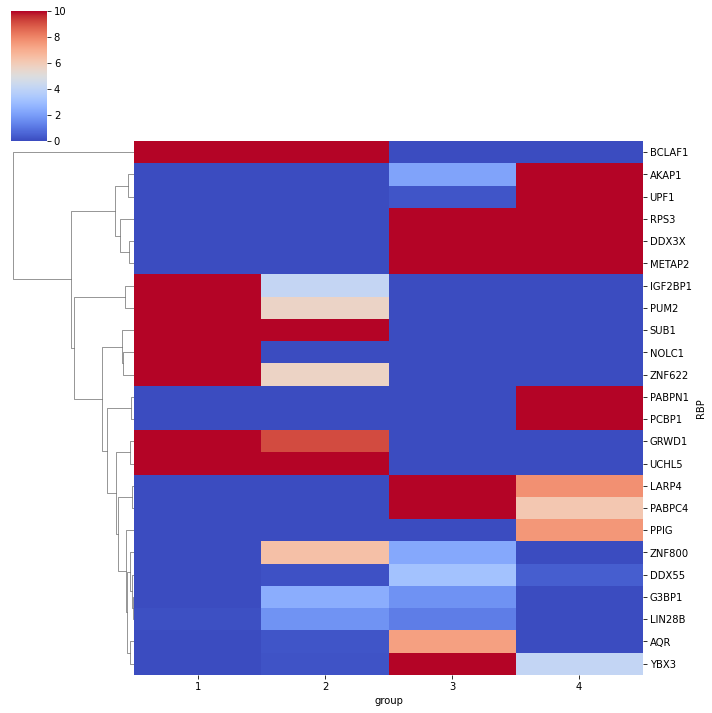

In [6]:
sns.clustermap(h9_rbp_enrich_at_rsq.fillna(0), col_cluster=False, vmax=10, cmap="coolwarm")

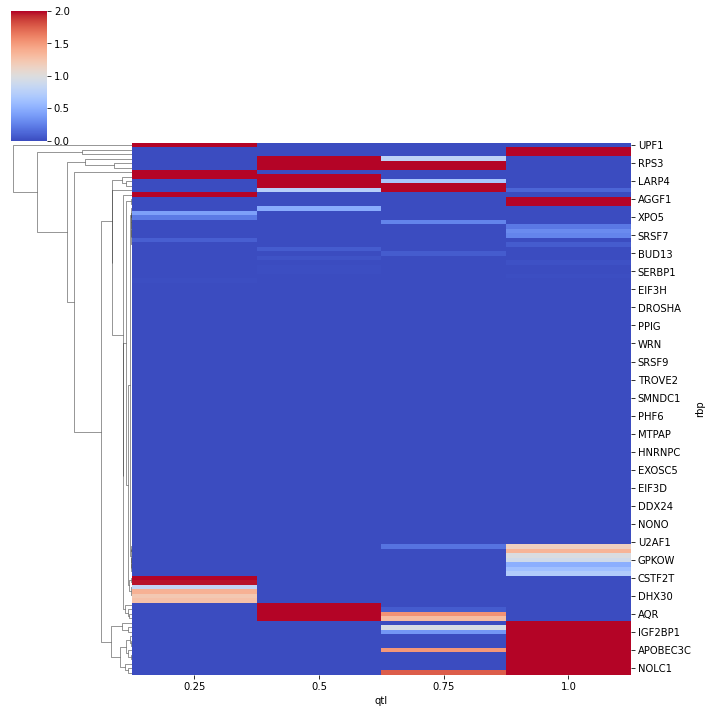

In [8]:
sns.clustermap(h9_rbp_enrich_at_reac.dropna(), col_cluster=False, vmax=2, cmap="coolwarm")

In [36]:
print (
h9_rbp_enrich_at_reac.loc[h9_rbp_enrich_at_reac[0.25]>-1*np.log10(0.05)].index.size,
h9_rbp_enrich_at_reac.loc[h9_rbp_enrich_at_reac[1]>-1*np.log10(0.05)].index.size)

print (
h9_rbp_enrich_at_rsq.loc[h9_rbp_enrich_at_rsq[1]>=-1*np.log10(0.05)].index.size,
h9_rbp_enrich_at_rsq.loc[h9_rbp_enrich_at_rsq[4]>=-1*np.log10(0.05)].index.size)

7 17
8 11


In [37]:
print (
h9_rbp_enrich_at_reac.loc[(h9_rbp_enrich_at_reac[0.25]>-1*np.log10(0.05))|(h9_rbp_enrich_at_reac[0.5]>-1*np.log10(0.05))].index.size,
h9_rbp_enrich_at_reac.loc[(h9_rbp_enrich_at_reac[1]>-1*np.log10(0.05))|(h9_rbp_enrich_at_reac[0.75]>-1*np.log10(0.05))].index.size)

print (
h9_rbp_enrich_at_rsq.loc[(h9_rbp_enrich_at_rsq[1]>=-1*np.log10(0.05))|(h9_rbp_enrich_at_rsq[2]>=-1*np.log10(0.05))].index.size,
h9_rbp_enrich_at_rsq.loc[(h9_rbp_enrich_at_rsq[3]>=-1*np.log10(0.05))|(h9_rbp_enrich_at_rsq[4]>=-1*np.log10(0.05))].index.size)

16 22
11 15


In [49]:
h9_rbp_enrich_at_rsq.to_csv("../Current_Data/07.RBP_targets/h9_rbp_enrich_at_rsq.zy_sort.csv")
h9_rbp_enrich_at_reac.to_csv("../Current_Data/07.RBP_targets/h9_rbp_enrich_at_reac.zy_sort.csv")

In [50]:
h9_rbp_enrich_at_rsq = h9_rbp_enrich_at_rsq.where(h9_rbp_enrich_at_rsq>-1*np.log10(0.05), False)
h9_rbp_enrich_at_rsq = h9_rbp_enrich_at_rsq.where(h9_rbp_enrich_at_rsq<-1*np.log10(0.05), True)
h9_rbp_enrich_at_rsq.to_csv("../Current_Data/07.RBP_targets/h9_rbp_enrich_at_rsq.zy_sort.boolean.csv")

h9_rbp_enrich_at_reac = h9_rbp_enrich_at_reac.where(h9_rbp_enrich_at_reac>-1*np.log10(0.05), False)
h9_rbp_enrich_at_reac = h9_rbp_enrich_at_reac.where(h9_rbp_enrich_at_reac<-1*np.log10(0.05), True)
h9_rbp_enrich_at_reac.to_csv("../Current_Data/07.RBP_targets/h9_rbp_enrich_at_reac.zy_sort.boolean.csv")

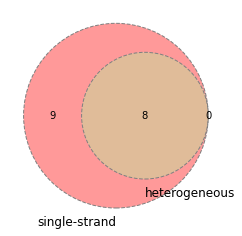

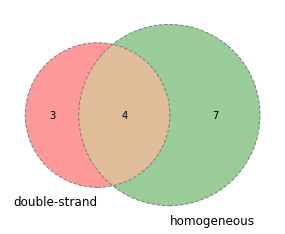

In [62]:
ss_enriched_rbps = set(h9_rbp_enrich_at_reac.loc[h9_rbp_enrich_at_reac[1.0]>-1*np.log10(0.05)].index.to_list())
ds_enriched_rbps = set(h9_rbp_enrich_at_reac.loc[h9_rbp_enrich_at_reac[0.25]>-1*np.log10(0.05)].index.to_list())

homo_enriched_rbps = set(h9_rbp_enrich_at_rsq.loc[h9_rbp_enrich_at_rsq[4]>-1*np.log10(0.05)].index.to_list())
hetero_enriched_rbps = set(h9_rbp_enrich_at_rsq.loc[h9_rbp_enrich_at_rsq[1]>-1*np.log10(0.05)].index.to_list())


from matplotlib_venn import venn2, venn2_circles, venn3, venn2_circles, venn3_circles

venn2([ss_enriched_rbps, hetero_enriched_rbps], ['single-strand', 'heterogeneous'])
venn2_circles([ss_enriched_rbps, hetero_enriched_rbps], linestyle='dashed', linewidth=1, color="grey")
plt.show()

venn2([ds_enriched_rbps, homo_enriched_rbps], ['double-strand', 'homogeneous'])
venn2_circles([ds_enriched_rbps, homo_enriched_rbps], linestyle='dashed', linewidth=1, color="grey")
plt.show()

In [63]:
ds_enriched_rbps

{'AKAP1', 'CSTF2T', 'DDX6', 'FMR1', 'PABPN1', 'PCBP1', 'UPF1'}

In [64]:
homo_enriched_rbps

{'AKAP1',
 'DDX3X',
 'LARP4',
 'METAP2',
 'PABPC4',
 'PABPN1',
 'PCBP1',
 'PPIG',
 'RPS3',
 'UPF1',
 'YBX3'}